In [3]:
import re
import os
import json
import nltk
import mpld3
import codecs
import numpy as np
import pandas as pd

from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/denisantyukhov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data preparation

### Read and preprocess the dataset containing movie plot summaries (synopses)

In [16]:
movie_data = json.load(open("../movie_synopses.json"))

In [17]:
titles = [m['title'] for m in movie_data]
synopses = [m['synopse'] for m in movie_data]
genres = [m['genre'] for m in movie_data]

In [5]:
titles[:5]

['Mr. Smith Goes to Washington',
 "It's a Wonderful Life",
 'Close Encounters of the Third Kind',
 'Star Wars',
 'West Side Story']

In [6]:
genres[:5]

[['Drama'],
 ['Drama', 'Family', 'Fantasy'],
 ['Drama', 'Sci-Fi'],
 ['Action', 'Adventure', 'Fantasy', 'Sci-Fi'],
 ['Crime', 'Drama', 'Musical', 'Romance', 'Thriller']]

Load english stopwords

In [18]:
stopwords = set(nltk.corpus.stopwords.words('english'))

Create an instance of [Snowball Stemmer](http://snowball.tartarus.org/) which is a part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is the process of breaking a word down into its root.

In [9]:
stemmer = SnowballStemmer("english")

In [10]:
# example:
stemmer.stem("playing")

'play'

In [10]:
# example:
stemmer.stem("networks")

'network'

### Define preprocessing functions

In [19]:
def tokenize_and_normalize(text):
    """
    Tokenizes input text by word, lowercases each token,
    removes punctuation and numeric tokens, then returns a list of tokens.
    """
    
    # tokenize text by word
    tokens = nltk.word_tokenize(text)
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token.lower())
    return filtered_tokens

### Exercise 2.1
Define a function that, in addition to tokening and normalizing text, applies stemming to each token

In [20]:
def tokenize_normalize_and_stem(text):
    """
    Tokenizes input text by word, lowercases each token,
    removes punctuation and numeric tokens, applies stemming to each token,
    then returns a list of stems.
    """
    
    # tokenize text by word
    tokens = nltk.word_tokenize(text)
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token.lower())
            
    # your code goes here
    token_stems = []
    for filtoken in filtered_tokens:
        token_stems.append(stemmer.stem(filtoken))
    return token_stems

In [21]:
assert tokenize_normalize_and_stem("Mary had a little lamb:: 111") == ['mari', 'had', 'a', 'littl', 'lamb']
print('done')

done


In [22]:
# preprocess all texts using both defined functions

allwords_stemmed = []
allwords_tokenized = []
for synopse in synopses:
    syn_toks = tokenize_and_normalize(synopse)
    allwords_tokenized += syn_toks
    
    syn_stems = tokenize_normalize_and_stem(synopse)
    allwords_stemmed += syn_stems
    
assert len(allwords_stemmed) == len(allwords_tokenized)
assert set([type(t) for t in allwords_tokenized+allwords_stemmed]) == {str}
print('done')

done


In [23]:
# make a mapping from a word's stem to a full word
stem_to_token = dict(zip(allwords_stemmed, allwords_tokenized))

In [16]:
stem_to_token['littl']

'little'

### Compute tf-idf representation

Here, we represent the *synopses* list with a [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) matrix. 

A couple things to note about the parameters defined below:

<ul>
<li> max_df: this is the maximum frequency a given feature can have within the documents to be used in the tf-idf matrix. If the term appears in more than 90% of the documents, it probably carries little meanining (in the context of movie synopses)
<li> min_idf: this is the maximum frequency a given feature can have within the documents to be used in the tf-idf matrix. This could be an integer (e.g. 3) and the term would have to appear in at least 3 of the documents to be considered. Or this could be a float (e.g 0.1), then the term must appear in at least 10% of the documents.
<li> ngram_range: this means that the model will use both unigrams and bigrams as potential features. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [17]:
# notice how we pass our own preprocessing pipeline to the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=10000,
                                   min_df=0.0, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_normalize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
terms = tfidf_vectorizer.get_feature_names()

# Compute pairwise distance matrix
dist = 1 - cosine_similarity(tfidf_matrix)
print(tfidf_matrix.shape)

CPU times: user 13.2 s, sys: 169 ms, total: 13.4 s
Wall time: 13.7 s
(100, 10000)


# K-means clustering

Using the tf-idf matrix, we can run a slew of clustering algorithms to better understand the hidden structure within the data. The first will be the [k-means](http://en.wikipedia.org/wiki/K-means_clustering) algorithm. K-means initializes with a pre-determined number of clusters. Each observation is assigned to a cluster (cluster assignment) so as to minimize sum of squares of distances within the cluster. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [18]:
num_clusters = 7
# initialize clustering
km = KMeans(n_clusters=num_clusters)

# compute K-Means clustering on TF-IDF representation
%time km.fit(tfidf_matrix)

# contains the cluster assignments for each observation
clusters = km.labels_.tolist()

# put the results of the clustering to a dataframe
films = { 'title': titles, 'rank': list(range(len(synopses))), 
         'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

# compute the clustering score (bigger is better)
km.score(tfidf_matrix)

CPU times: user 1.15 s, sys: 16.8 ms, total: 1.16 s
Wall time: 1.2 s


-89.6859794155763

In [24]:
def printout_clusters(kmeans, num):

    cluster_to_words = {}
    print("Top terms per cluster:\n")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(num):
        print("Cluster {} words: ".format(i), end='')
        term_ids = order_centroids[i, :8]

        cluster_words = []
        for term_id in term_ids:
            term = terms[term_id]
            if ' ' in term:
                cluster_words += [stem_to_token[t] for t in term.split()]
            else:
                cluster_words.append(stem_to_token[term])

        cluster_to_words[i] = ', '.join(cluster_words)
        print(cluster_to_words[i])

        print("Cluster {} titles:".format(i), end='')
        try:
            titles = frame.loc[i]['title'].values.tolist()
        except:
            titles = [frame.loc[i]['title']]
        for title in titles:
            print(' {},'.format(title), end='')
        print("\n\n")
    return cluster_to_words

In [20]:
cluster_to_words = printout_clusters(km, num_clusters)

Top terms per cluster:

Cluster 0 words: willard, rose, cal, kurtz, jack, fran, budding, sheldrake
Cluster 0 titles: The Apartment, Apocalypse Now, Titanic,


Cluster 1 words: 's, michael, don, rocky, alex, mike, wallace, shark
Cluster 1 titles: West Side Story, The Deer Hunter, The Best Years of Our Lives, Gladiator, E.T. the Extra-Terrestrial, Network, From Here to Eternity, Rocky, The Godfather, Giant, City Lights, Goodfellas, Pulp Fiction, The Philadelphia Story, Singin' in the Rain, The French Connection, Gandhi, Doctor Zhivago, Jaws, The Grapes of Wrath, Amadeus, A Clockwork Orange, It Happened One Night, Lawrence of Arabia, Tootsie, Mutiny on the Bounty, Braveheart, To Kill a Mockingbird, The Godfather: Part II,


Cluster 2 words: terry, shane, joey, curt, jake, roy, ufo, barry
Cluster 2 titles: Close Encounters of the Third Kind, American Graffiti, Raging Bull, Shane, On the Waterfront,


Cluster 3 words: kane, smith, raymond, charlie, annie, miller, alvy, 's
Cluster 3 titles: 

### Top terms defining each cluster are dominated by proper nouns (names). This is not a good thing, because proper nouns carry little to no semantic information about the movie synopse. 
### To achieve better clustering, we have to get rid of them.

To that end, we will use NLTK Part of Speech tagger which will help us filter unwanted words from text

In [21]:
pos_tag(nltk.word_tokenize("Alice sent Bob an encrypted message"))

[('Alice', 'NNP'),
 ('sent', 'VBD'),
 ('Bob', 'NNP'),
 ('an', 'DT'),
 ('encrypted', 'JJ'),
 ('message', 'NN')]

### Exercise 2.2
Using the 'pos_tag' function, define a function that filters proper nouns from raw text. 
The words you want to remove are tagged 'NNP' and 'NNPS'

In [25]:
def remove_proper_nouns_from_text(text):
    """
    Removes all tokens tagged as NNP or NNPS from input string.
    Returns a new string.
    """
    # your code goes here
    tokens = nltk.word_tokenize(text)
    tagged = pos_tag(tokens) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return ' '.join(non_propernouns)

In [26]:
assert remove_proper_nouns_from_text("Alice sent Bob an encrypted message") == 'sent an encrypted message'
print('done')

done


### Exercise 2.3
Using your new function, preprocess the dataset and remove all proper nouns.
Then, recompute the TF-IDF matrix and the K-Means clustering.
As a result, your clustering score should increase.

In [27]:
# your code goes here
pos_filtered_synopses = [remove_proper_nouns_from_text(s) for s in synopses]

In [28]:
# your code goes here
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=10000,
                                   min_df=0.0, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_normalize_and_stem,
                                   ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(pos_filtered_synopses)
dist = 1 - cosine_similarity(tfidf_matrix)
terms = tfidf_vectorizer.get_feature_names()

In [29]:
num_clusters = 7
# initialize clustering
km = KMeans(n_clusters=num_clusters)

# compute K-Means clustering on TF-IDF representation
%time km.fit(tfidf_matrix)

# contains the cluster assignments for each observation
clusters = km.labels_.tolist()

# put the results of the clustering to a dataframe
films = { 'title': titles, 'rank': list(range(len(synopses))), 
         'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

# compute the clustering score (bigger is better)
new_score = km.score(tfidf_matrix)
print('New clustering score: {}'.format(new_score))
assert new_score > -85
print('done')

CPU times: user 1.1 s, sys: 33.6 ms, total: 1.14 s
Wall time: 1.16 s
New clustering score: -82.6203177391726
done


In [30]:
cluster_to_words = printout_clusters(km, num_clusters)

Top terms per cluster:

Cluster 0 words: bus, wedding, 's, father, shrimp, money, agree, king
Cluster 0 titles: Out of Africa, The Philadelphia Story, Midnight Cowboy, It Happened One Night, Braveheart, Forrest Gump,


Cluster 1 words: 's, soldier, killed, german, commanding, orders, men, war
Cluster 1 titles: Star Wars, The Deer Hunter, Gladiator, The Treasure of the Sierra Madre, From Here to Eternity, Raiders of the Lost Ark, Apocalypse Now, The King's Speech, Shane, Schindler's List, Saving Private Ryan, The Bridge on the River Kwai, All Quiet on the Western Front, The Pianist, The Lord of the Rings: The Return of the King, Doctor Zhivago, Patton, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Lawrence of Arabia, Dances with Wolves, Casablanca, Platoon,


Cluster 2 words: boats, shark, 's, lake, water, christian, captain, necklace
Cluster 2 titles: The Sound of Music, A Place in the Sun, Jaws, The African Queen, Titanic, Mutiny on the Bounty,


Cluster 3 word

### This looks better, but there is more we can do here. To improve the quality of our representation, we could remove the very frequent and very infrequent words from our TF-IDF matrix. This should make the clusters more diverse and distinguishable

### Exercise 2.4
Experiment with tfidf_vectorizer parameters min_df and max_df to downsample most frequent and least frequent terms.
Find the parameters that give a clustering score > -70, but leave at least 500 features for your representationn.

In [31]:
# your code goes here
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_normalize_and_stem,
                                   ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(pos_filtered_synopses)
terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)
print("Features left: {}".format(len(terms)))

Features left: 547


In [32]:
num_clusters = 7
# initialize clustering
km = KMeans(n_clusters=num_clusters)

# compute K-Means clustering on TF-IDF representation
%time km.fit(tfidf_matrix)

# contains the cluster assignments for each observation
clusters = km.labels_.tolist()

# put the results of the clustering to a dataframe
films = { 'title': titles, 'rank': list(range(len(synopses))), 
         'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

# compute the clustering score (bigger is better)
new_score = km.score(tfidf_matrix)
print('New clustering score: {}'.format(new_score))
assert new_score > -70
assert len(terms) > 500
print('done')

CPU times: user 815 ms, sys: 13.7 ms, total: 829 ms
Wall time: 856 ms
New clustering score: -65.84871029005245
done


In [33]:
cluster_to_words = printout_clusters(km, num_clusters)

Top terms per cluster:

Cluster 0 words: soldier, commanding, men, officer, orders, killed, attacked, wounded
Cluster 0 titles: From Here to Eternity, Apocalypse Now, Saving Private Ryan, The Bridge on the River Kwai, All Quiet on the Western Front, The Lord of the Rings: The Return of the King, Patton, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Lawrence of Arabia, Mutiny on the Bounty, Dances with Wolves, Platoon,


Cluster 1 words: family, father, killed, son, marry, meets, brother, home
Cluster 1 titles: The Sound of Music, Gladiator, The Treasure of the Sierra Madre, The Silence of the Lambs, Gone with the Wind, The Godfather, Rain Man, The King's Speech, Giant, A Place in the Sun, Ben-Hur, Goodfellas, The Philadelphia Story, The Pianist, Doctor Zhivago, The Grapes of Wrath, Rebel Without a Cause, Amadeus, It Happened One Night, Braveheart, To Kill a Mockingbird, The Godfather: Part II, Forrest Gump,


Cluster 2 words: killed, police, car, guns, murdered,

### Good enough!

# Visualizing document clusters with multidimensional scaling

In [34]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [35]:
#set up colors per clusters using a dict
cluster_colors = {i: np.random.rand(3,) for i in range(num_clusters)}

#set up cluster names using a dict
cluster_names = cluster_to_words

In [36]:
%matplotlib inline

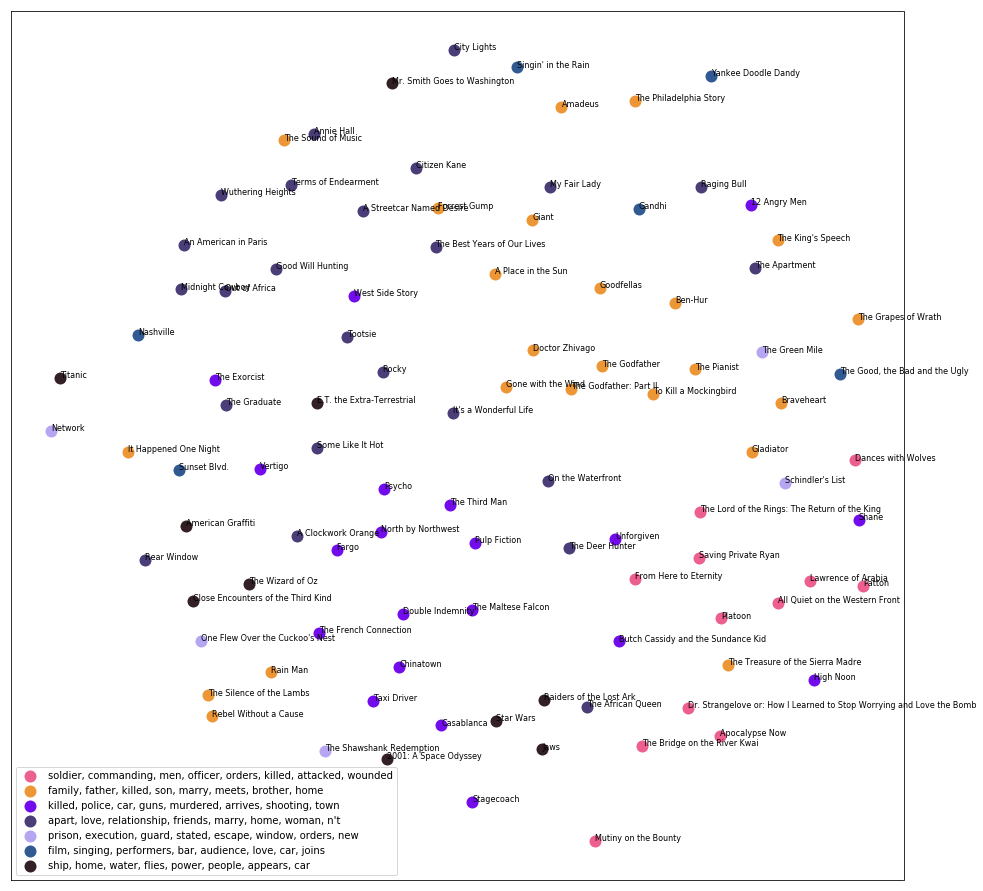

In [37]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(16, 16)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
plt.show() #show the plot
plt.close()

In [48]:
from vis_utils import css, TopToolbar

In [49]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling


# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

# Hierarchical document clustering

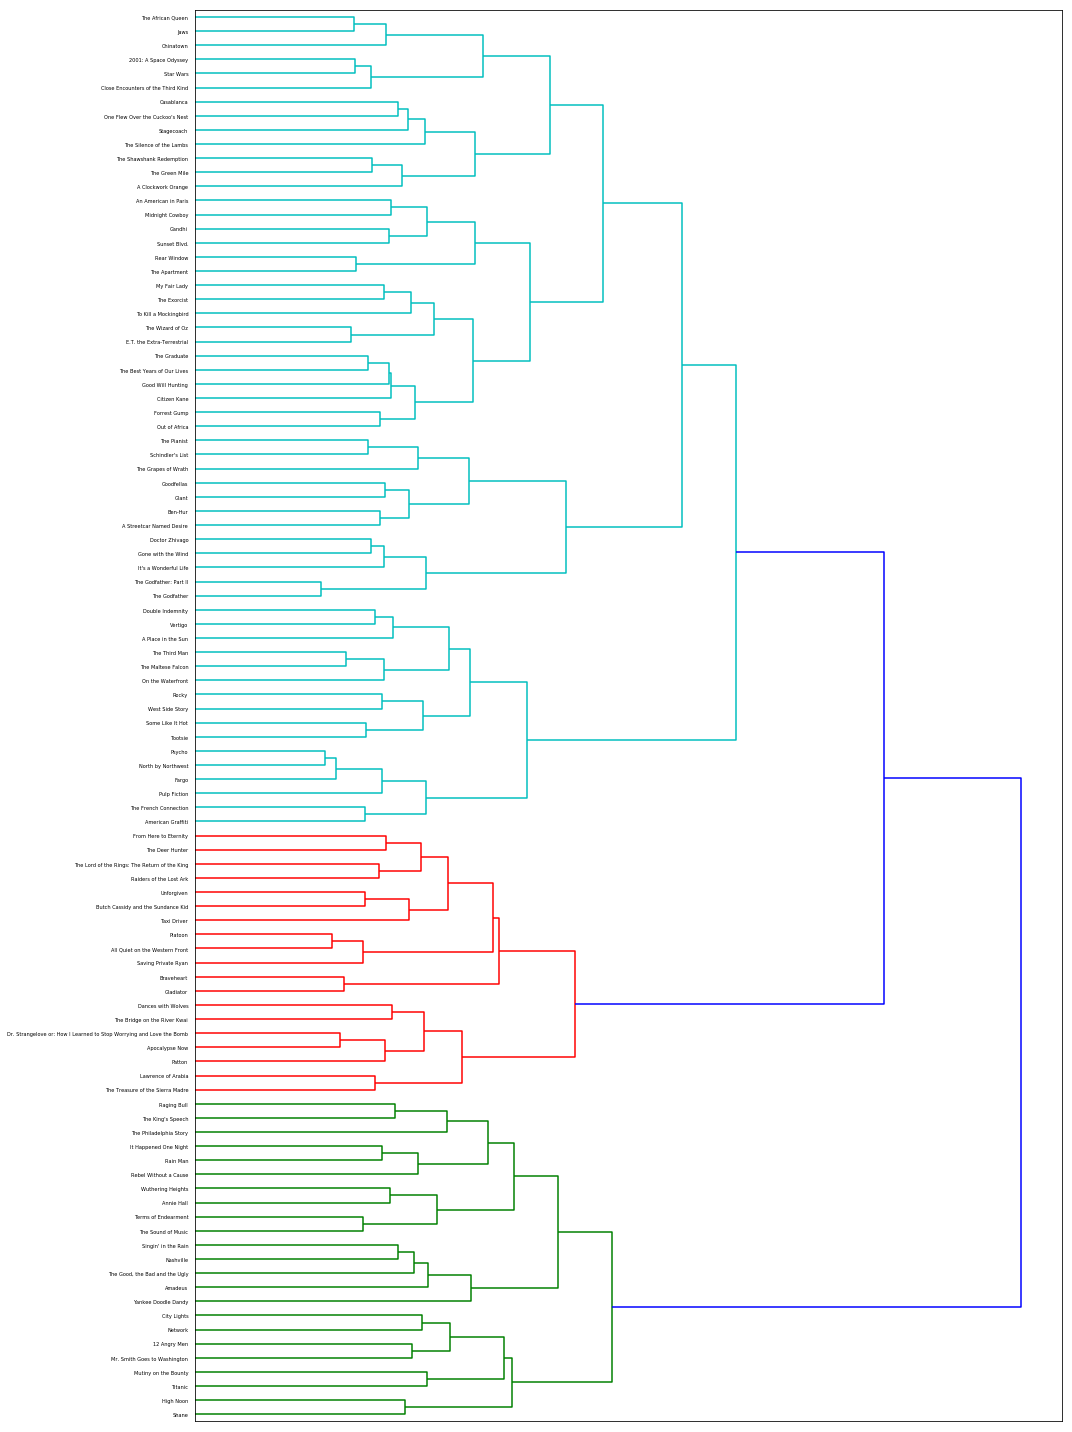

In [38]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters